In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/amsurve/PROJECTS/gg2/data/bbc_cleaned.csv')

In [3]:
df.shape

(2225, 7)

In [4]:
df.sample(5)    

,Unnamed: 0,Unnamed: 0.1,category,title,text,label,cleaned_text
1936,1936,1936,tech,EU software patent law faces axe,EU software patent law faces axe\n\nThe Europe...,0,eu software patent law face axe european parli...
37,37,37,entertainment,Day-Lewis set for Berlin honour,Day-Lewis set for Berlin honour\n\nActor Danie...,3,daylewis set berlin honour actor daniel presen...
1619,1619,1619,politics,Falconer rebuts 'charade' claims,Falconer rebuts 'charade' claims\n\nConcession...,4,falconer rebuts charade claim concession bill ...
789,789,789,business,Profits slide at India's Dr Reddy,Profits slide at India's Dr Reddy\n\nProfits a...,1,profit slide indias dr reddy indian drugmaker ...
703,703,703,business,Weak end-of-year sales hit Next,Weak end-of-year sales hit Next\n\nNext has sa...,1,weak endofyear sale hit next annual profit low...


In [5]:
label_df = df[['category', 'label']].drop_duplicates().sort_values('label').reset_index().drop('index',1)
label_df

,category,label
0,tech,0
1,business,1
2,sport,2
3,entertainment,3
4,politics,4


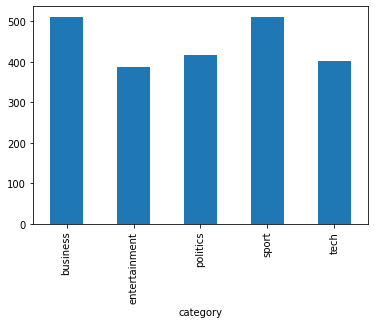

In [6]:
df.groupby('category').label.count().plot.bar(ylim=0)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.cleaned_text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = df.label                           # represents the category of each of the 1490 articles
print(features.shape )

(2225, 9288)


In [8]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

### Wordcloud for entire data

In [ ]:
texts = ''
for index, item in df.iterrows():
    texts = texts + ' ' + item['cleaned_text']
    
plot_word_cloud(texts)

### Wordcloud for each category

In [9]:
def plot_word_cloud_for_category(df, category):
    text_df = df.loc[df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + item['cleaned_text']
    
    plot_word_cloud(texts)


In [ ]:
plot_word_cloud_for_category(df,'business')

In [ ]:
plot_word_cloud_for_category(df,'tech')

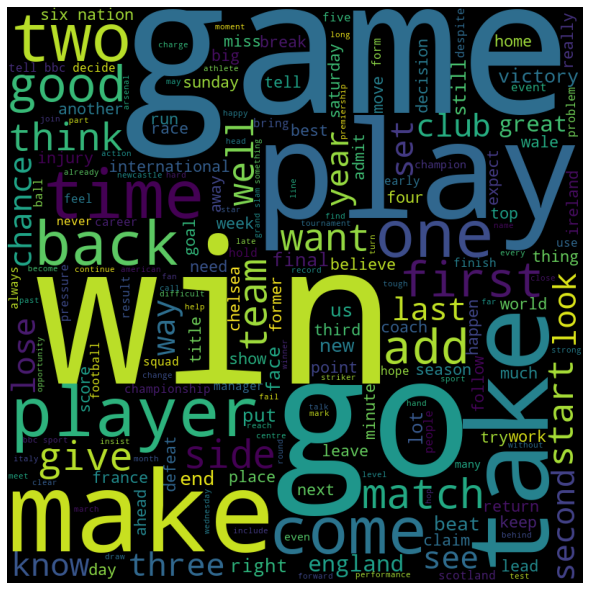

In [10]:
plot_word_cloud_for_category(df,'sport')

In [ ]:
plot_word_cloud_for_category(df,'entertainment')

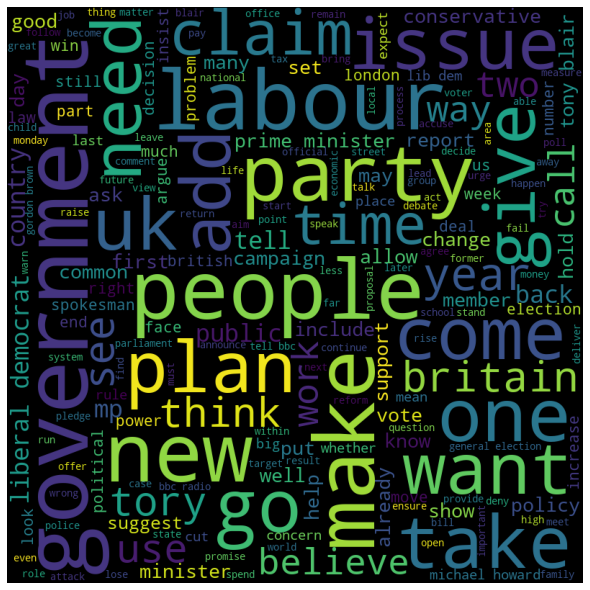

In [11]:
plot_word_cloud_for_category(df,'politics')

## Top unigrams and bigrams

In [12]:
from sklearn.feature_selection import chi2
category2label = {'tech':0,'business':1,'sport':2,'entertainment':3,'politics':4}
N = 3  # We are going to look for top 3 categories

for category, label in sorted(category2label.items()):
    features_chi2 = chi2(features, labels == label)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print('*'*50)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat
print('*'*50)

**************************************************
# 'business':
  . Most correlated unigrams:
       . analyst
       . bank
       . growth
  . Most correlated bigrams:
       . chief executive
       . oil price
       . stock market
**************************************************
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . film
       . actor
  . Most correlated bigrams:
       . dollar baby
       . los angeles
       . box office
**************************************************
# 'politics':
  . Most correlated unigrams:
       . election
       . labour
       . tory
  . Most correlated bigrams:
       . michael howard
       . tony blair
       . liberal democrat
**************************************************
# 'sport':
  . Most correlated unigrams:
       . cup
       . champion
       . coach
  . Most correlated bigrams:
       . champion league
       . bbc sport
       . grand slam
**************************************************
# '

## Topic modelling

In [13]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below
number_topics = 3
number_words = 4

def sw_removal(text):
  stopwords = nltk.corpus.stopwords.words('english')
  newStopWords = ["net","peer","eu"]
  stopwords.extend(newStopWords)
  word_filtered = []
  words = text.split()
  for w in words:
    if w not in stopwords:
        word_filtered.append(w)
  unique = list(dict.fromkeys(word_filtered))
  return " ".join(unique)

In [14]:
label_0 = df.loc[df['label'] == 0, "title"]
label_1 = df.loc[df['label'] == 1, "title"]
label_2 = df.loc[df['label'] == 2, "title"]
label_3 = df.loc[df['label'] == 3, "title"]
label_4 = df.loc[df['label'] == 4, "title"]


In [15]:
label_0 = label_0.apply(sw_removal)
label_1 = label_1.apply(sw_removal)
label_2 = label_2.apply(sw_removal)
label_3 = label_3.apply(sw_removal)
label_4 = label_4.apply(sw_removal)


In [16]:
label0_vectorizer = TfidfVectorizer()
label0 = label0_vectorizer.fit_transform(label_0)
label0_lda = LDA(n_components=number_topics, n_jobs=-1)
label0_lda.fit(label0)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [17]:
label1_vectorizer = TfidfVectorizer()
label1 = label1_vectorizer.fit_transform(label_1)
label1_lda = LDA(n_components=number_topics, n_jobs=-1)
label1_lda.fit(label1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [18]:
label2_vectorizer = TfidfVectorizer()
label2 = label2_vectorizer.fit_transform(label_1)
label2_lda = LDA(n_components=number_topics, n_jobs=-1)
label2_lda.fit(label2)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [19]:
label3_vectorizer = TfidfVectorizer()
label3 = label3_vectorizer.fit_transform(label_3)
label3_lda = LDA(n_components=number_topics, n_jobs=-1)
label3_lda.fit(label3)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [20]:
label4_vectorizer = TfidfVectorizer()
label4 = label4_vectorizer.fit_transform(label_4)
label4_lda = LDA(n_components=number_topics, n_jobs=-1)
label4_lda.fit(label4)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [21]:
# Print the topics found by the LDA model
print("Topics found in Technology via LDA:")
print_topics(label0_lda, label0_vectorizer, number_words)
print(" ")
print("Topics found in Business via LDA:")
print_topics(label1_lda, label1_vectorizer, number_words)
print(" ")
print("Topics found in Sports via LDA:")
print_topics(label2_lda, label2_vectorizer, number_words)
print(" ")
print("Topics found in Entertainment via LDA:")
print_topics(label3_lda, label3_vectorizer, number_words)
print(" ")
print("Topics found in Politics via LDA:")
print_topics(label4_lda, label4_vectorizer, number_words)


Topics found in Technology via LDA:

Topic #0:
gadget peer offers to

Topic #1:
microsoft future takes tv

Topic #2:
mobile apple games gets
 
Topics found in Business via LDA:

Topic #0:
yukos china lse court

Topic #1:
shares bank economy india

Topic #2:
us growth hits jobs
 
Topics found in Sports via LDA:

Topic #0:
hits shares economy bank

Topic #1:
us yukos deal oil

Topic #2:
us profits prices bid
 
Topics found in Entertainment via LDA:

Topic #0:
show us singer top

Topic #1:
box office film star

Topic #2:
awards film oscars dies
 
Topics found in Politics via LDA:

Topic #0:
blair brown election terror

Topic #1:
labour howard new campaign

Topic #2:
mps uk plan plans


In [22]:
from pyLDAvis import sklearn as sklearn_lda
import pickle
import pyLDAvis

In [23]:
LDAvis_prepared0 = sklearn_lda.prepare(label0_lda, label0, label0_vectorizer)
LDAvis_prepared1 = sklearn_lda.prepare(label1_lda, label1, label1_vectorizer)
LDAvis_prepared2 = sklearn_lda.prepare(label2_lda, label2, label2_vectorizer)
LDAvis_prepared3 = sklearn_lda.prepare(label3_lda, label3, label3_vectorizer)
LDAvis_prepared4 = sklearn_lda.prepare(label4_lda, label4, label4_vectorizer)

In [24]:
pyLDAvis.display(LDAvis_prepared0)